# EW contour plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
file_path = "emission_lines_1hden_2phi.txt"

# Read the file with ISO-8859-1 encoding
df = pd.read_csv(file_path, sep="\t", engine="python")
#df = pd.read_csv(file_path, sep="\t", encoding="ISO-8859-1", engine="python")

# Display the first few rows
print(df.head())

    #lineslist  Inci 1215.00A   C  4 1550.77A   H  1 4861.32A   \
0  iteration 3       1810400.0        266920.0         31203.0   
1  iteration 4       3219400.0        460010.0         48033.0   
2  iteration 4       5725100.0        245390.0         62813.0   
3  iteration 4      10181000.0         32195.0         46672.0   
4  iteration 3      18104000.0         19157.0         35783.0   

   H  1 6562.80A   C  3 1908.73A   
0        149830.0       33606.000  
1        242500.0       42581.000  
2        191660.0        3011.300  
3        130500.0          67.521  
4         97880.0          16.307  


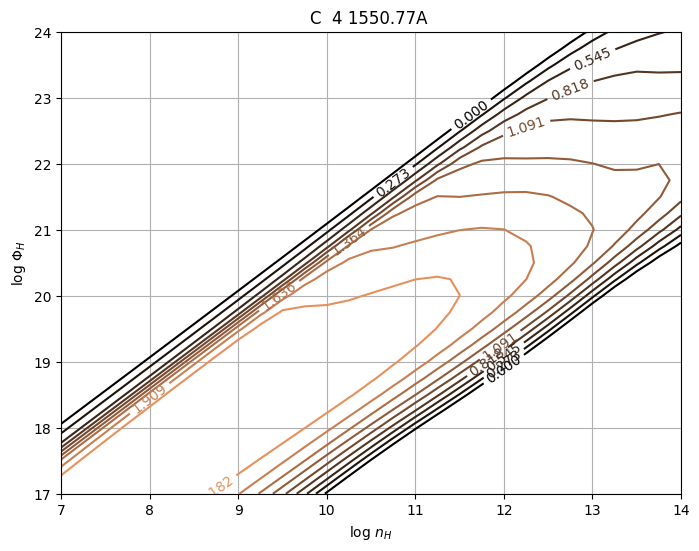

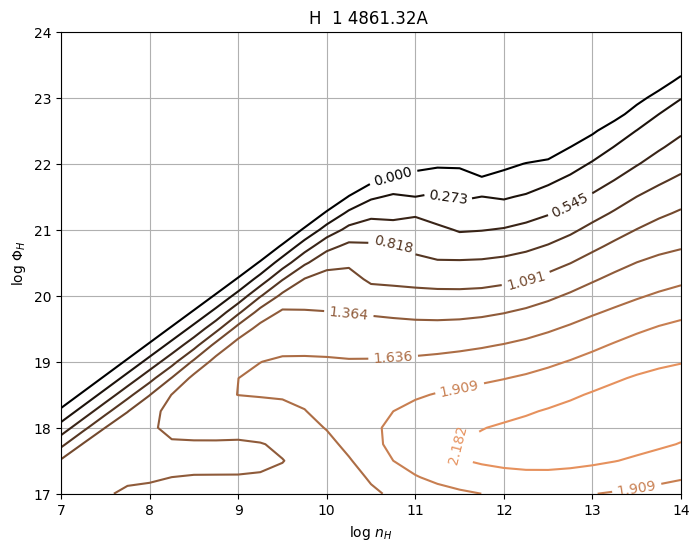

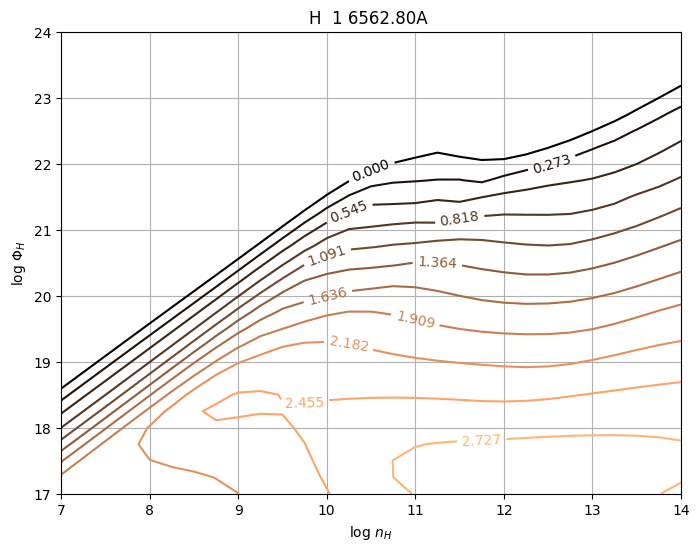

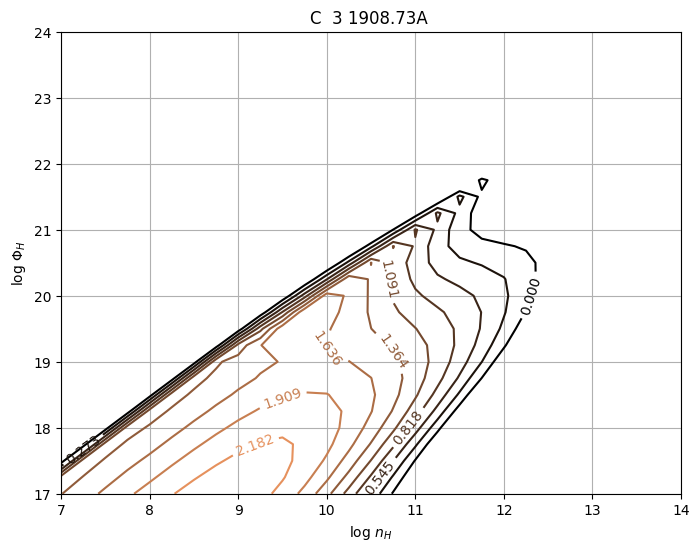

In [9]:
def plot_ew_contours_general(file_path,
                             Nx,                     # number of x-points
                             Ny,                     # number of y-points
                             x_min,                  # minimum of x-linspace
                             x_max,                  # maximum of x-linspace
                             y_min,                  # minimum of y-linspace
                             y_max,                  # maximum of y-linspace,
                             ref_col="Inci 1215.00A ",
                             log_levels=(0, 3),
                             n_levels=12):
    """
    A function for plotting EW contours.
    You can specify Nx, Ny, along with the min/max for each axis. 
    The function checks that Nx * Ny == number of rows in your CSV.
    If that's correct, it reshapes each emission line array to Nx-by-Ny,
    then transpose, and finally contour.

    Parameters
    ----------
    file_path : str
        Path to your emission line data file.
    Nx, Ny : int
        Dimensions of your 2D grid. Nx * Ny must match the total rows in the CSV.
    x_min, x_max, y_min, y_max : float
        Bounds for the linspace on x- and y-axes. We create Nx points for x, Ny points for y.
    ref_col : str
        Name of the reference column (e.g., "Inci 1215.00A") used for normalization, of each emission line strength.
    log_levels : tuple
        The (min, max) range in log space for the contour levels.
    n_levels : int
        How many contour levels to draw between log_levels[0] and log_levels[1].
    """

    # ------------------------------------------------
    # 1) Read data
    # ------------------------------------------------
    df = pd.read_csv(file_path, sep="\t", encoding="ISO-8859-1", engine="python")
    total_rows = len(df)

    # Sanity check that Nx * Ny == total_rows
    if Nx * Ny != total_rows:
        raise ValueError(
            f"Specified Nx * Ny = {Nx * Ny}, but your file has {total_rows} rows. "
            "They must match."
        )

    # ------------------------------------------------
    # 2) Verify the reference flux column
    # ------------------------------------------------
    if ref_col not in df.columns:
        print(f"Error: '{ref_col}' column not found in dataset.")
        return

    # Convert reference flux to numeric array
    H1_1215_flux = pd.to_numeric(df[ref_col], errors="coerce").values

    # ------------------------------------------------
    # 3) Construct x, y arrays
    # ------------------------------------------------
    x = np.linspace(x_min, x_max, Nx)
    y = np.linspace(y_min, y_max, Ny)

    # ------------------------------------------------
    # 4) Loop over columns and plot
    # ------------------------------------------------
    for col_name in df.columns:
        # Skip reference column
        if col_name == ref_col or col_name == "#lineslist":
            continue

        # Convert flux to numeric
        flux_vals = pd.to_numeric(df[col_name], errors="coerce").values

        # Ensure emission line values ≥ 1 BEFORE normalization
        flux_vals[flux_vals < 1] = 1

        # Normalize line flux by reference flux
        flux_normalized = flux_vals / H1_1215_flux

        # Log-transform
        log_flux = np.log10(flux_normalized * 1215.0)

        # Reshape to Nx-by-Ny
        Z = log_flux.reshape(Nx, Ny)

        # Transpose if you want y rows and x columns (typical in contour calls):
        # i.e., so that Z[i, j] corresponds to x[i], y[j].
        # Mike's code did:
        #     rotZ = np.array(list(zip(*Z)))
        # That’s effectively just `Z.T`.
        rotZ = Z.T

        # Make contour levels
        levels = np.linspace(log_levels[0], log_levels[1], n_levels)

        # Plot contour
        plt.figure(figsize=(8, 6))
        CS = plt.contour(x, y, rotZ, levels=levels, cmap="copper")
        plt.clabel(CS, inline=True, fontsize=10)
        plt.xlabel(r"log $n_{H}$")
        plt.ylabel(r"log $\Phi_{H}$")
        plt.title(col_name)
        plt.grid(True)
        plt.show()

# Example usage:
plot_ew_contours_general("emission_lines_1hden_2phi.txt", Nx=29, Ny=29, x_min=7.0, x_max=14.0, y_min=17.0,  y_max=24.0)